# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from sklearn.metrics import confusion_matrix, r2_score

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import loading_utils
from backend import metrics_utils
from backend import skill_prediction_utils

# Load Basin Attributes for Latitude & Longitude

In [4]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [5]:
attributes = loading_utils.load_attributes_file(gauges=gauges)

# Load Return Period Metrics

In [6]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [7]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [8]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Skill Predictability

## Extract Basin Attributes as Classifier/Regression Inputs

In [9]:
# A subset of attributes to use as predictor values. This selection is mostly
# due to challenges in naming all the HydroATLAS variables, and the skill
# is not affected by removing some of the landcover class variables.
ATTRIBUTE_DESCRIPTIVE_NAMES = {
    'calculated_drain_area': 'Drain Area',
    'inu_pc_umn': 'Inundation Percent Min',
    'inu_pc_umx': 'Inundation Percent Max',
    # 'inu_pc_ult': 'Inundation Percent Long Term Maximum',
    'lka_pc_use': 'Precent Lake Area',
    'lkv_mc_usu': 'Lake Volume',
    'rev_mc_usu': 'Reservoir Volume',
    'ria_ha_usu': 'River Area',
    'riv_tc_usu': 'River Volume',
    'ele_mt_uav': 'Elevation',
    'slp_dg_uav': 'Slope',
    'tmp_dc_uyr': 'Air Temperature',
    'pre_mm_uyr': 'Precipitation',
    'pet_mm_uyr': 'PET',
    'aet_mm_uyr': 'AET',
    'ari_ix_uav': 'Aridity Index',
    'cmi_ix_uyr': 'Climate Moisture Index',
    'snw_pc_uyr': 'Snow Cover Extent',
    'for_pc_use': 'Forest Cover Extent',
    'crp_pc_use': 'Cropland Extent',
    'pst_pc_use': 'Pastiure Extent',
    'ire_pc_use': 'Irrigated Area Extent',
    'gla_pc_use': 'Glacier Extent',
    'prm_pc_use': 'Permafrost Extent',
    'pac_pc_use': 'Protected Area Extent',
    'cly_pc_uav': 'Soil Clay Fraction',
    'slt_pc_uav': 'Soil Silt Fraction',
    'snd_pc_uav': 'Soil Sand Fraction',
    'soc_th_uav': 'Soil Organic Carbon',
    'swc_pc_uyr': 'Soil Water Content',
    'kar_pc_use': 'Karst Area Extent',
    'ero_kh_uav': 'Soil Erosion',
    'pop_ct_usu': 'Population Count',
    'ppd_pk_uav': 'Population Density',
    'urb_pc_use': 'Urban Area Extent',
    'nli_ix_uav': 'Nighttime Lights Index',
    # 'rdd_mk_uav': 'Road Density',
    # 'hft_ix_u93': 'Human Footprint 1993',
    # 'hft_ix_u09': 'Human Footprint 2009',
    'gdp_ud_usu': 'GDP',
    # 'latitude': 'latitude',
    # 'longitude': 'longitude',
}

# Select the subset of attributes.
regression_attributes = attributes[ATTRIBUTE_DESCRIPTIVE_NAMES.keys()]
regression_attributes.rename(columns=ATTRIBUTE_DESCRIPTIVE_NAMES, inplace=True)

# Normalize the attributes.
regression_attributes = (regression_attributes - regression_attributes.mean()) / regression_attributes.std()

/tmp/ipykernel_209265/1900861654.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_attributes.rename(columns=ATTRIBUTE_DESCRIPTIVE_NAMES, inplace=True)


## Hyperparameters for Reliability Score Predictions

In [10]:
# Hyperparamters for reliability score predictions.
lead_time = 0
return_period = 5
metric='F1 Score'

# Predict Which Model is Better Where

In [11]:
glofas_data = f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
    lead_time][return_period].dropna().rename('glofas')
google_data = f1s_by_lead_time['google_1980']['kfold_splits'][
    lead_time][return_period].dropna().rename('google')

regression_data = pd.concat([glofas_data, google_data], axis=1).dropna()
regression_data = (regression_data['glofas'] - regression_data['google']).rename('winner')

bins = [-1e100, -1e-6, 1e-6, 1e100]

metric = 'winner'
x, y = skill_prediction_utils.make_predictors(
    x=regression_attributes,
    y=regression_data,
    metric=metric,
    bins=bins
)

y_hat = skill_prediction_utils.train_kfold(
    x, y,
    classifier=True
#     regression=True
)

There are 36 predictors.
There are 3360 samples.


0it [00:00, ?it/s]

Training fold # 0


1it [00:02,  2.79s/it]

Training fold # 1


2it [00:05,  2.80s/it]

Training fold # 2


3it [00:08,  2.79s/it]

Training fold # 3


4it [00:11,  2.78s/it]

Training fold # 4


5it [00:13,  2.79s/it]

Training fold # 5


6it [00:16,  2.80s/it]

Training fold # 6


7it [00:19,  2.79s/it]

Training fold # 7


8it [00:22,  2.80s/it]

Training fold # 8


9it [00:25,  2.80s/it]

Training fold # 9


10it [00:27,  2.79s/it]

Training fold # 10


11it [00:30,  2.79s/it]

Training fold # 11


12it [00:33,  2.81s/it]

Training fold # 12


13it [00:36,  2.82s/it]

Training fold # 13


14it [00:39,  2.81s/it]

Training fold # 14


15it [00:42,  2.84s/it]

Training fold # 15


16it [00:45,  3.00s/it]

Training fold # 16


17it [00:48,  2.95s/it]

Training fold # 17


18it [00:51,  2.90s/it]

Training fold # 18


19it [00:54,  2.90s/it]

Training fold # 19


20it [00:56,  2.87s/it]

Training fold # 20


21it [00:59,  2.85s/it]

Training fold # 21


22it [01:02,  2.82s/it]

Training fold # 22


23it [01:05,  2.81s/it]

Training fold # 23


24it [01:07,  2.80s/it]

Training fold # 24


25it [01:10,  2.83s/it]


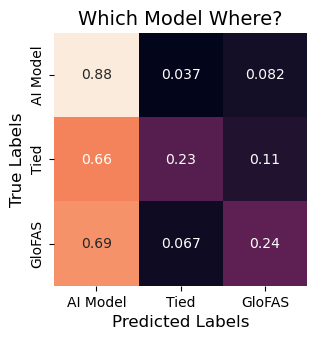

In [13]:
fig, ax = plt.subplots(
    1, 1, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['one_column'],
        evaluation_utils.NATURE_FIG_SIZES['one_column']
    )
)

cm = confusion_matrix(y, y_hat, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2g', ax=ax, cbar=False)
ax.set_aspect('equal', 'box')
ax.set_xlabel(
    'Predicted Labels', 
    fontsize=12
)
ax.set_ylabel(
    'True Labels', 
    fontsize=12
)
ax.set_title(
    'Which Model Where?', 
    fontsize=14
);
ax.xaxis.set_ticklabels(
    ['AI Model', 'Tied', 'GloFAS'],
    fontsize=10
)
ax.yaxis.set_ticklabels(
    ['AI Model', 'Tied', 'GloFAS'], 
    fontsize=10
)

plt.tight_layout()

evaluation_utils.save_figure(data_paths.PREDICTABILITY_WHICH_MODEL_IS_BETTER)